## Notebook entrainement environement pettingzoo

Dans ce notebook je presente l'entrainement de l'environement simple reference v3 de la bibliotheque mpe de petting zoo. C'est un environement coopératif dans lequel on a 3 mark (rouge, bleu, vert) et 2 agents d'une des trois couleurs les agents on pour but de ce diriger vers la marque de leurs couleurs (les deux agents peuvent etre de la meme couleurs). Les agents connaise la position des marks de l'autre agent mais pas la leur. Ils parle et ecoute tous les deux. Leurs but et de maximiser une récompence qui est composé de leurs distance a leurs objectif et de la distance moyen, ca les encourage a apprendre à bien communiquer.

Dans un premier temps on importe l'ensemble des dependance nécessaire au bon fonctionement de l'algorithme

In [1]:
import torch

# Tensordict modules
from tensordict.nn import set_composite_lp_aggregate, TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
# from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs
from torchrl.envs.libs.pettingzoo import PettingZooEnv

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\data\replay_buffers\samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


## Hyperparamétres

On définie les resource matériel qui seront utiliser pour l'entrainement et la simulation (environement). On définie aussi les hyperparamétres pour l'échantilonage et l'entrainement. L'agorithme que l'on utilisera sera PPO un algorithme on policy qui supporte les espace d'entrée et de sortie continue et qui offre un entrainement trés stable.

In [2]:
seed = 0
torch.manual_seed(seed)

is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
print(device)

vmas_device = device

# Sampling
frames_per_batch = 6_000    # Number of team frames collected per training iteration
n_iters = 100               # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30             # Number of optimization steps per training iteration
minibatch_size = 400        # Size of the mini-batches in each optimization step
lr = 3e-4                   # Learning rate
max_grad_norm = 1.0         # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2          # clip value for PPO loss
gamma = 0.99                # discount factor
lmbda = 0.9                 # lambda for generalised advantage estimation
entropy_eps = 1e-4          # coefficient of the entropy term in the PPO loss

# disable log-prob aggregation
set_composite_lp_aggregate(False).set()

cpu


### Envionement 
L'environement utiliser est importer depuis pettingzoo il s'agit du "simple_reference_v3" on le paramétre de maniére a ce qu'il fonctione en parallele avec un ration de entre les récompence global et local, un maximum de 25 cycle par simulation et des actions continue.

In [6]:
env = PettingZooEnv(
    task="simple_reference_v3",
    parallel=True,                  # Les actions des deux agents sont pris simultanement
    seed=seed,                      
    local_ratio=0.5,                # Ratio entre la récompence global et la récompence local
    max_cycles=25,                  # Nombre d'action avant que l'environemen sois terminer
    continuous_actions=False,        # L'espace des action est continue
)

c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:1019: UserWarning: PettingZoo failed to load all modules with error message No module named 'multi_agent_ale_py', trying to load individual modules.
  warnings.warn(
c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:52: UserWarning: SISL environments failed to load with error message No module named 'Box2D'.
  warnings.warn(f"SISL environments failed to load with error message {err}.")
c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:58: UserWarning: Classic environments failed to load with error message No module named 'chess'.
  warnings.warn(f"Classic environments failed to load with error message {err}.")
c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\envs\libs\pettingzoo.py:64: UserWarning: Atari environment

In [7]:
# print(f"group_map: {env.group_map}")
print("action_spec:", env.full_action_spec)
# print("reward_spec:", env.full_reward_spec)
# print("done_spec:", env.full_done_spec)
# print("observation_spec:", env.observation_spec)
print("action_keys:", env.action_keys)
# print("reward_keys:", env.reward_keys)
# print("done_keys:", env.done_keys)

action_spec: Composite(
    agent: Composite(
        action: Categorical(
            shape=torch.Size([2]),
            space=CategoricalBox(n=50),
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        device=None,
        shape=torch.Size([2]),
        data_cls=None),
    device=None,
    shape=torch.Size([]),
    data_cls=None)
action_keys: [('agent', 'action')]


On ajoute une sortie a l'environement qui somme l'ensemble des récompence de la sumulation autrement on ne peut avoir que la récompence de l'action et on ne dispose d'aucun suivie global des recompence. Cette récompence est tres importante pour comparer les performances des different modéle car elle permet d'avoir une vrai idée sur les capacité du modèle.

In [8]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agent", "episode_reward")]),
)

In [9]:
check_env_specs(env)

2025-08-01 15:21:24,911 [torchrl][INFO]    check_env_specs succeeded! [END]


Simumation de test pour voir si tous ce passe comme prévu dans l'environement 

In [10]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agent: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([5, 2]), device=cpu, dtype=torch.int64, is_shared=False),
                done: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([5, 2, 21]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([5, 2]),
            device=None,
            is_shared=False),
        done: Tensor(shape=torch.Size([5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            

## Politique 

L'agorithme utilisé pour l'entrainement est PPO. Cette algorithme implique par sont fonctionement qu'il y a plsieur mobule nécessaire en plus du réseaux il est necessaire de séparer les moyenne et les ecart type (policy module) les compiner pour obtenir les actions (policy) et on a besoin d'un raiseau critique pour le calcul de la loss qui est nécessaire au bonee entrainment du systeme.

In [16]:
share_parameters_policy = True

# reseaux pour des actions continue
# policy_net = torch.nn.Sequential(
#     MultiAgentMLP(
#         n_agent_inputs=env.observation_spec["agent", "observation"].shape[-1],  # n_obs_per_agent
#         n_agent_outputs=2 * env.full_action_spec[env.action_key].shape[-1],  # 2 * n_actions_per_agents
#         n_agents=2,
#         centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
#         share_params=share_parameters_policy,
#         device=device,
#         depth=2,
#         num_cells=256,
#         activation_class=torch.nn.Tanh,
#     ),
#     NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
# )

# reseaux pour des actions discrete
policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agent", "observation"].shape[-1],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[env.action_key].space.n, # 50
        n_agents=2,
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)


50


In [15]:
# Continue 
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agent", "observation")],
    out_keys=[("agent", "loc"), ("agent", "scale")],
)

# Discrete
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agent", "observation")],
    out_keys=[("agent", "logits")],
)

In [ ]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec_unbatched,
    in_keys=[("agent", "loc"), ("agent", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.full_action_spec_unbatched[env.action_key].space.low,
        "high": env.full_action_spec_unbatched[env.action_key].space.high,
    },
    return_log_prob=True,
)  # we'll need the log-prob for the PPO loss

In [12]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agent", "observation"].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=2,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agent", "observation")],
    out_keys=[("agent", "state_value")],
)

In [13]:
# print("Running policy:", policy(env.reset()))
# print("Running value:", critic(env.reset()))

In [14]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

print(f"frames_per_batch : {frames_per_batch}, total_frames : {total_frames}")
print(total_frames/frames_per_batch)

frames_per_batch : 6000, total_frames : 600000
100.0


In [15]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

In [16]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    value=("agent", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agent", "done"),
    terminated=("agent", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

c:\Users\FX643778\AppData\Local\anaconda3\envs\pythorch_class\lib\site-packages\torchrl\objectives\ppo.py:450: DeprecationWarning: 'entropy_coef' is deprecated and will be removed in torchrl v0.11. Please use 'entropy_coeff' instead.
  warnings.warn(


In [17]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agent", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agent", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agent", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agent", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 0:   0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: action is not in action space

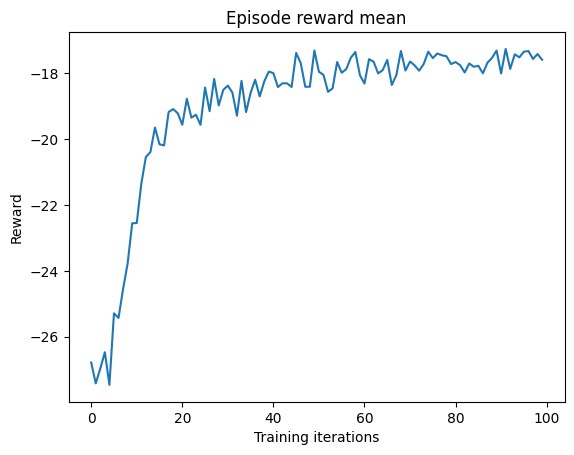

In [22]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

In [ ]:
from tensordict import TensorDict
from pettingzoo.mpe import simple_reference_v3

env = simple_reference_v3.env(render_mode="human", continuous_actions=True)
env.reset()

obs_vide = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
obs_agent1 = torch.tensor(obs_vide, dtype=torch.float32) 
sum_reward = 0


# Pour avoir acces aux fonction render de petting zoo il faut etre en mode ACS donc on doit traiter les agent 1 par 1
# C'est ce que permet cette boucle on traite l'agent 0 puis 1 en boucle
for agent in env.agent_iter():
    env.render()
    observation, reward, termination, truncation, info = env.last()
    sum_reward += reward/2

    if termination or truncation:
        action = None
    else:
        if agent == "agent_0":
            obs_agent0 = torch.tensor(observation, dtype=torch.float32)
        else:
            obs_agent1 = torch.tensor(observation, dtype=torch.float32)

        
        obs_agents = torch.stack([obs_agent0, obs_agent1], dim=0)
        input_td = TensorDict(
            source={("agent", "observation"): obs_agents},
            batch_size=[2], 
        ) 
        out = policy(input_td)

        if agent == "agent_0":
            action = out.get(("agent", "action"))[0]
        else:
            action = out.get(("agent", "action"))[1]
        action = action.detach().cpu().numpy()
    env.step(action)
env.close()

print(sum_reward)


-17.1088383702198
